In [2]:
# ==============================================================================
# CELL 1: Installing the Necessary Libraries
# ==============================================================================
print("Setting up the environment... This might take a couple of minutes.")

# We need to install the base Graphviz library for our causal graphs
!apt-get install -y graphviz -qq

# Now, let's install all the required Python packages
!pip install -q "gymnasium[classic-control]" stable-baselines3 sb3-contrib pandas matplotlib seaborn econml graphviz

print("All set! Libraries are installed and we're ready to go.")

Setting up the environment... This might take a couple of minutes.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 13.8 MB/s eta 0:00:00
All set! Libraries are installed and we're ready to go.


Part 1: Starting the Model Training Process with enhanced exploration...


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Using cpu device


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



--- STARTING TRAINING PHASE 1/2 ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------
| time/              |      |
|    fps             | 773  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 648          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 4.880625e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.39        |
|    explained_variance   | 1.4e-05      |
|    learning_rate        | 0.0001       |
|    loss                 | 1.41e+08     |
|    n_updates            | 10           |
|    policy_gradient_loss | -6.57e-05    |
|    value_loss           | 2.66e+08     |
------------------------------------------
----------------

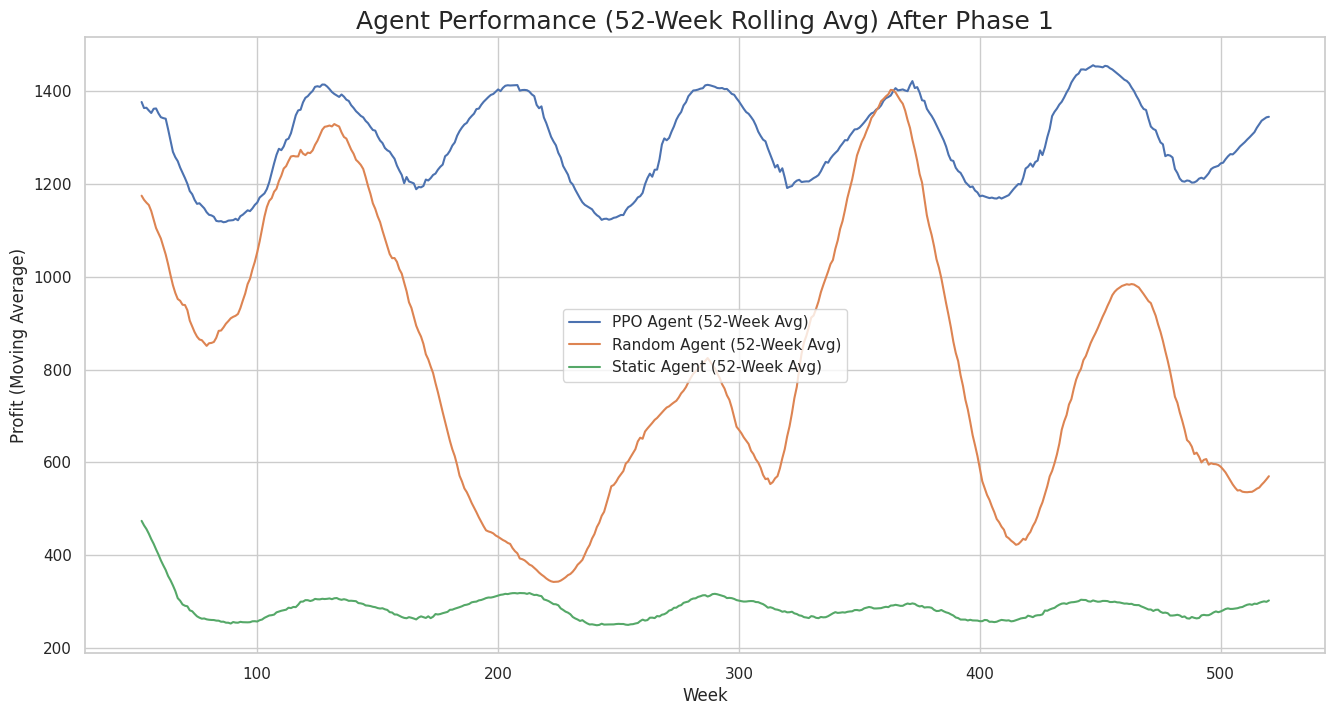

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



--- STARTING TRAINING PHASE 2/2 ---
-------------------------------
| time/              |        |
|    fps             | 796    |
|    iterations      | 1      |
|    time_elapsed    | 2      |
|    total_timesteps | 303104 |
-------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 682           |
|    iterations           | 2             |
|    time_elapsed         | 6             |
|    total_timesteps      | 305152        |
| train/                  |               |
|    approx_kl            | 5.7339203e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.36         |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0001        |
|    loss                 | 1.77e+08      |
|    n_updates            | 1480          |
|    policy_gradient_loss | -8.75e-05     |
|    value_loss           | 3.75e+0

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


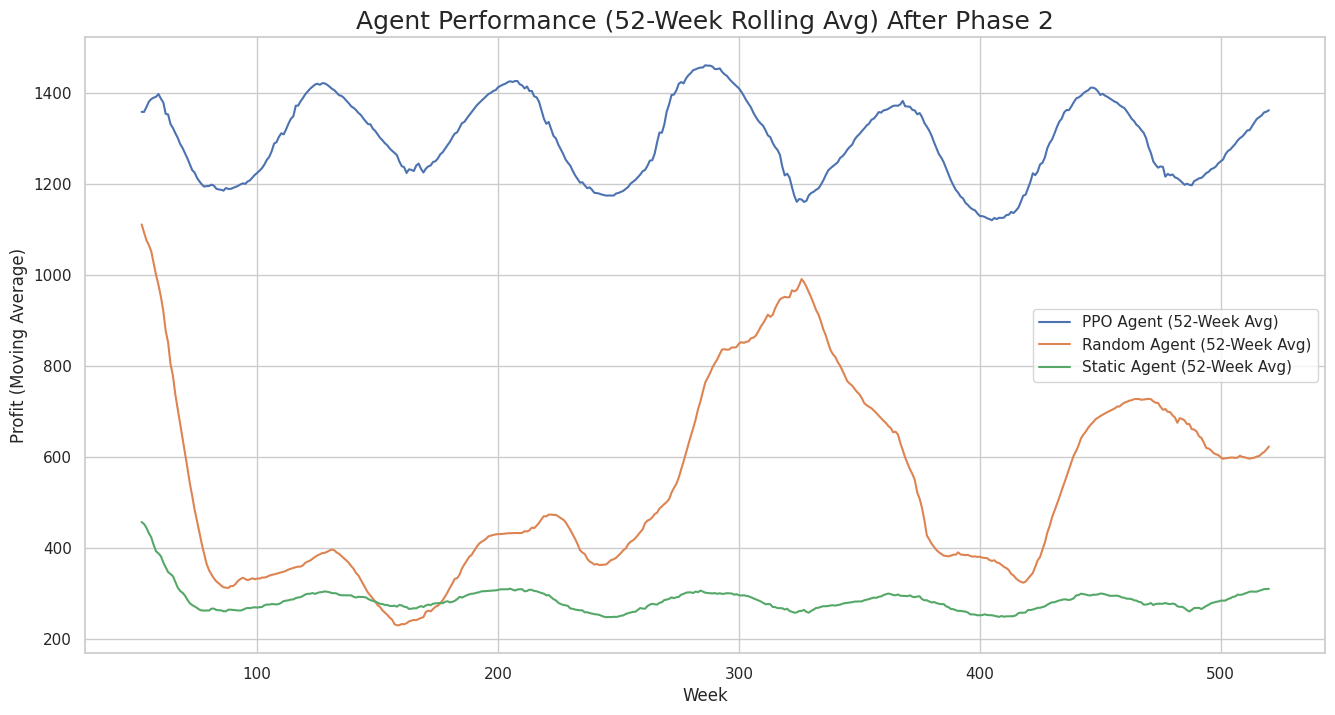


ALL TRAINING PHASES COMPLETE!
The final, trained model is saved as 'ppo_causal_pricing_model_phase_2.zip'.
You will need this file for the next cell where we do the causal analysis.
total 284
-rw-r--r-- 1 root root 141127 Aug 25 05:51 ppo_causal_pricing_model_phase_1.zip
-rw-r--r-- 1 root root 141132 Aug 25 06:00 ppo_causal_pricing_model_phase_2.zip
drwxr-xr-x 1 root root   4096 Aug 21 13:41 sample_data


In [3]:
# ==============================================================================
# CELL 2: Model Training (part1_training.py) - MORE EXPLORATION V2
# ==============================================================================
print("Part 1: Starting the Model Training Process with enhanced exploration...")

# First, let's import the tools we will need for training
import numpy as np
import pandas as pd
import os
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# A little bit of setup to make our plots look nice
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (16, 8)

# --- Environment Definition ---
# This is the heart of our project: the custom world where our agent will learn.
class CausalPricingEnv(gym.Env):
    def __init__(self, num_weeks=104):
        super().__init__()
        self.num_weeks = num_weeks; self.current_week = 0; self.base_price = 25; self.base_volume = 100;
        self.cost = 12.0; self.action_space = spaces.Discrete(4);
        self.observation_space = spaces.Box(low=-1, high=10, shape=(6,), dtype=np.float32)
        self.loyalty = 1.0; self.economic_trend = 1.0; self.past_discount = 0.0; self.current_discount = 0.0
    def reset(self, seed=None, options=None):
        super().reset(seed=seed); self.current_week = 0; self.loyalty = 1.0; self.economic_trend = 1.0;
        self.past_discount = 0.0; self.current_discount = 0.0; return self._get_obs(), {}
    def _get_obs(self):
        seasonality = 1 + 0.3 * np.sin(2 * np.pi * self.current_week / 52)
        competitor_discounts = np.random.choice([0.0, 0.1, 0.2, 0.3], p=[0.2, 0.3, 0.3, 0.2], size=3)
        competitor_avg_discount = np.mean(competitor_discounts)
        self.economic_trend = 1 + 0.2 * np.sin(2 * np.pi * self.current_week / 80) + np.random.normal(0, 0.05)
        return np.array([self.current_week % 52, seasonality, competitor_avg_discount, self.loyalty, self.economic_trend, self.past_discount], dtype=np.float32)
    def step(self, action):
        discount_levels = {0: 0.0, 1: 0.1, 2: 0.2, 3: 0.3}
        if self.current_week % 13 == 0: self.current_discount = discount_levels.get(action, 0.0)
        discount = self.current_discount; seasonality = 1 + 0.3 * np.sin(2 * np.pi * self.current_week / 52)
        competitor_avg_discount = self._get_obs()[2]; our_price = self.base_price * (1 - discount)
        avg_competitor_price = self.base_price * (1 - competitor_avg_discount)
        stockpiling_factor = max(0.5, 1 - (self.past_discount * 2.0))
        price_effect = np.log(1 + (self.base_price - our_price) / self.base_price * 5) + 1; loyalty_effect = self.loyalty ** 1.5
        competitor_price_ratio = avg_competitor_price / our_price
        competitor_impact = competitor_price_ratio ** 3 if competitor_price_ratio < 1.0 else competitor_price_ratio ** 0.5
        demand = self.base_volume * seasonality * loyalty_effect * self.economic_trend * stockpiling_factor * price_effect * competitor_impact
        if discount == 0.0: self.loyalty = max(self.loyalty - 0.02, 0.5)
        elif 0 < discount <= 0.2: self.loyalty = min(self.loyalty + 0.03, 1.3)
        else: self.loyalty = max(self.loyalty - 0.03, 0.5)
        self.past_discount = discount; profit = (our_price - self.cost) * demand; reward = profit
        if self.loyalty > 1.0: reward += (self.loyalty - 1.0) * 500
        if self.loyalty < 1.0: reward -= (1.0 - self.loyalty) * 1000
        if our_price < avg_competitor_price: reward += 300
        self.current_week += 1; terminated = self.current_week >= self.num_weeks; truncated = False
        info = {"profit": profit, "discount": discount}
        return self._get_obs(), reward, terminated, truncated, info

# A helper function to see how well our agent is doing after each training phase.
def run_evaluation_simulation(env_class, agent_policy, num_weeks, agent_name):
    eval_env = env_class(num_weeks=num_weeks)
    obs, _ = eval_env.reset()
    data_points = []
    for _ in range(num_weeks):
        if agent_name == "PPO Agent":
            action, _ = agent_policy.predict(obs, deterministic=True)
            action = action.item()
        elif agent_name == "Random Agent":
            action = eval_env.action_space.sample()
        else: # Static Agent
            action = 0
        obs, _, terminated, truncated, info = eval_env.step(action)
        data_points.append({"week": eval_env.current_week, "profit": info["profit"], "agent": agent_name})
        if terminated or truncated: break
    total_profit = pd.DataFrame(data_points)['profit'].sum()
    print(f"-> Total Profit for {agent_name}: {total_profit:,.2f}")
    return pd.DataFrame(data_points)

# --- Training Configuration ---
MODEL_BASENAME = "ppo_causal_pricing_model"
NUM_WEEKS_PER_EPISODE = 208
# UPDATED: Increased training time for more experience
TOTAL_TIMESTEPS_PER_PHASE = 300_000
NUM_PHASES = 2

# --- PPO Hyperparameters ---
# These settings define how our agent learns.
ppo_params = {
    # UPDATED: Slower learning rate for more stable updates
    "learning_rate": 0.0001,
    "n_steps": 2048,
    "batch_size": 64,
    "n_epochs": 10,
    "gamma": 0.99,
    # UPDATED: Aggressive entropy coefficient to force exploration
    "ent_coef": 0.1
}

# --- Main Training Process ---
# Wrap the environment so the RL library can use it
env = DummyVecEnv([lambda: CausalPricingEnv(num_weeks=NUM_WEEKS_PER_EPISODE)])

# Let's clear out any old model files to start fresh.
for i in range(1, NUM_PHASES + 1):
    if os.path.exists(f"{MODEL_BASENAME}_phase_{i}.zip"):
        os.remove(f"{MODEL_BASENAME}_phase_{i}.zip")
        print(f"Removed old model file: {MODEL_BASENAME}_phase_{i}.zip")

# Create the PPO model
model = PPO("MlpPolicy", env, verbose=1, **ppo_params)

# Start the phased training loop
for i in range(NUM_PHASES):
    phase_num = i + 1
    print("\n" + "="*60)
    print(f"--- STARTING TRAINING PHASE {phase_num}/{NUM_PHASES} ---")
    print("="*60)

    # The main learning step
    model.learn(total_timesteps=TOTAL_TIMESTEPS_PER_PHASE, reset_num_timesteps=(i==0))

    # Save the model at the end of this phase
    model_path_phase = f"{MODEL_BASENAME}_phase_{phase_num}.zip"
    model.save(model_path_phase)
    print(f"\nModel saved to: {model_path_phase}")

    # --- Post-Phase Evaluation ---
    print("\n--- Evaluating performance after this phase... ---")
    num_eval_weeks = 520 # Let's test the agent over a 10-year period

    ppo_df = run_evaluation_simulation(CausalPricingEnv, model, num_eval_weeks, "PPO Agent")
    random_df = run_evaluation_simulation(CausalPricingEnv, None, num_eval_weeks, "Random Agent")
    static_df = run_evaluation_simulation(CausalPricingEnv, None, num_eval_weeks, "Static Agent")

    # FIX: Add 'ignore_index=True' to create a new, unique index for the combined DataFrame.
    all_data = pd.concat([ppo_df, random_df, static_df], ignore_index=True)

    # Time to visualize the progress!
    plt.figure(figsize=(16, 8))
    # We use a rolling average to smooth out the weekly noise and see the trend.
    for agent_name, group in all_data.groupby('agent'):
        plt.plot(group['week'], group['profit'].rolling(52).mean(), label=f"{agent_name} (52-Week Avg)")

    plt.title(f"Agent Performance (52-Week Rolling Avg) After Phase {phase_num}", fontsize=18)
    plt.xlabel("Week")
    plt.ylabel("Profit (Moving Average)")
    plt.legend()
    plt.grid(True)
    plt.show()

print("\n" + "="*60)
print("ALL TRAINING PHASES COMPLETE!")
final_model_path = f"{MODEL_BASENAME}_phase_{NUM_PHASES}.zip"
print(f"The final, trained model is saved as '{final_model_path}'.")
print("You will need this file for the next cell where we do the causal analysis.")
print("="*60)

# Let's verify the file was created
!ls -l

Part 2: Starting Causal Analysis and Visualization...
--- Starting Detailed Simulation for Analysis ---
Trained model loaded successfully from 'ppo_causal_pricing_model_phase_2.zip'
Running simulation for PPO Agent...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Running simulation for Random Agent...
Running simulation for Static Agent...
Simulation data saved to 'simulation_results.csv' for future runs.


--- SECTION 2: METHODOLOGY VISUALS ---

-> Generating Figure 2.1: The Causal Model (DAG)...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


   Saved as 'Causal_DAG_Final.png'.


--- SECTION 3.1: AGENT PERFORMANCE ANALYSIS ---

-> Generating Table 3.1: Key Performance Indicators (KPIs)...
          Agent  Total Profit  Average Weekly Profit  \
0     PPO Agent     670793.68                1289.99   
1  Random Agent     512124.79                 984.86   
2  Static Agent     158837.45                 305.46   

   Profit Volatility (Std Dev)  
0                       439.79  
1                       518.64  
2                       135.27  


-> Generating Figure 3.1: Cumulative Profit Performance...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


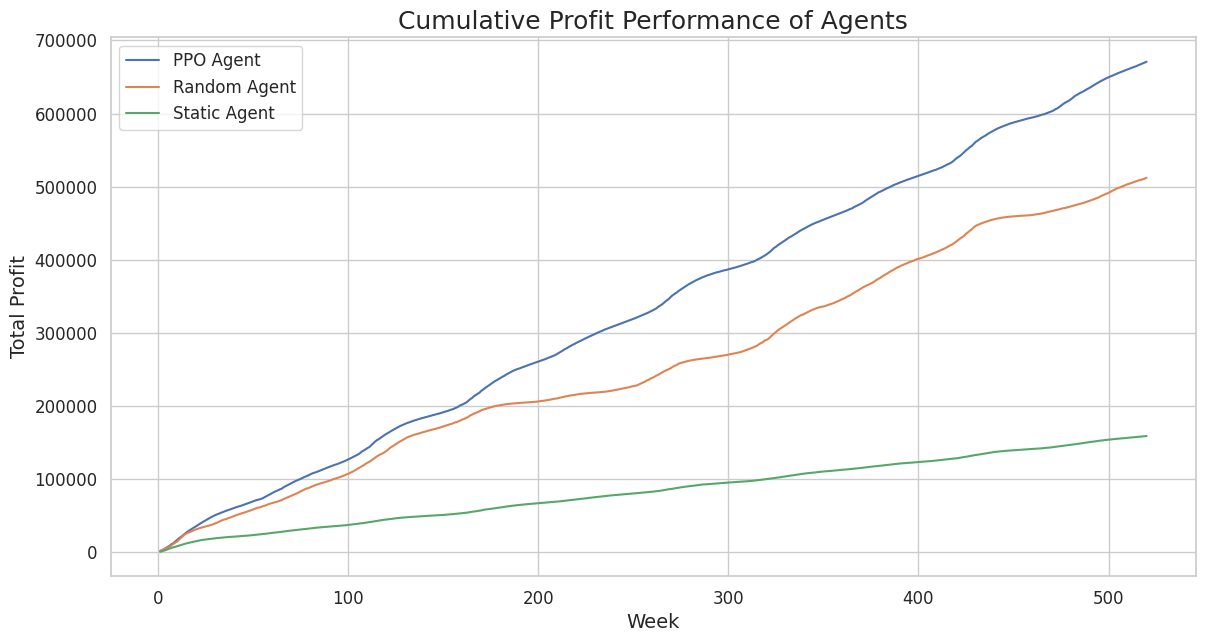

-> Generating Figure 3.2: 52-Week Rolling Average Profit...


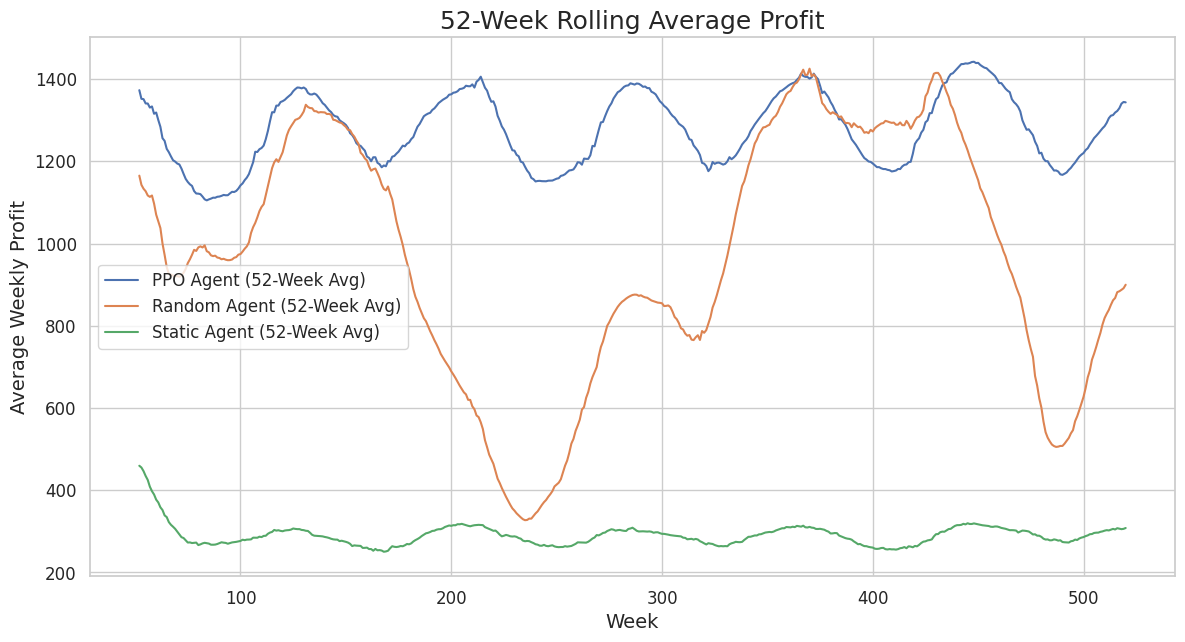


--- SECTION 3.2: PPO AGENT'S POLICY ANALYSIS ---

-> Generating Figure 3.3: PPO Agent's Discount Distribution...


/tmp/ipython-input-1024388120.py:147: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='discount', data=decision_points, palette='viridis', order=[0.0, 0.1, 0.2, 0.3])
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


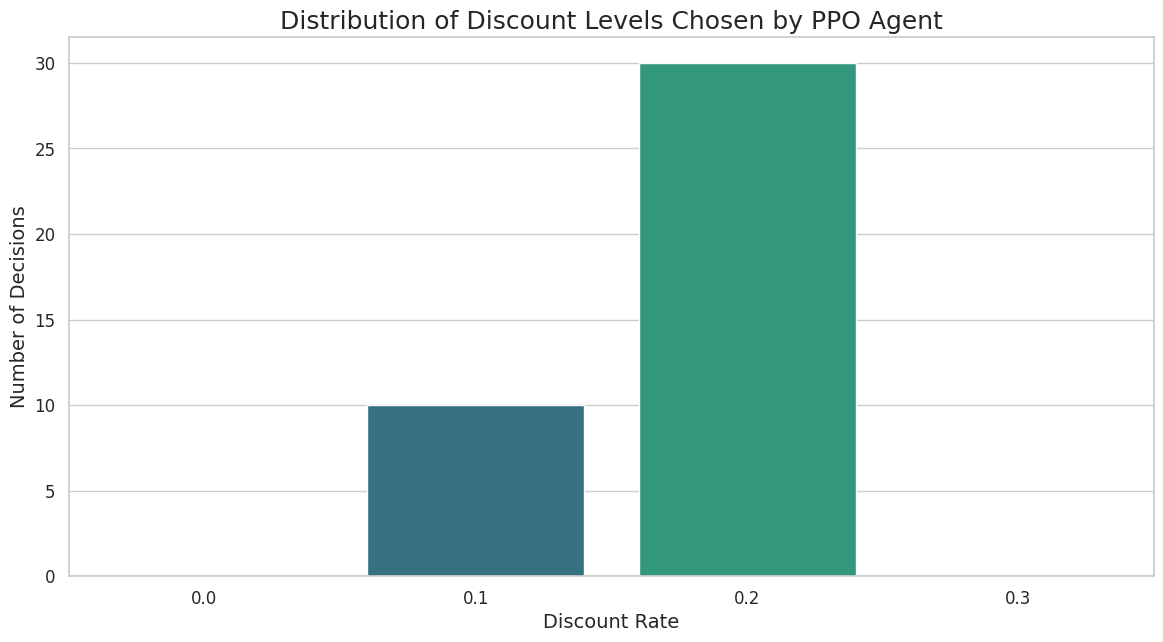

-> Generating Figure 3.4: PPO Agent's Decisions vs. Seasonality...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


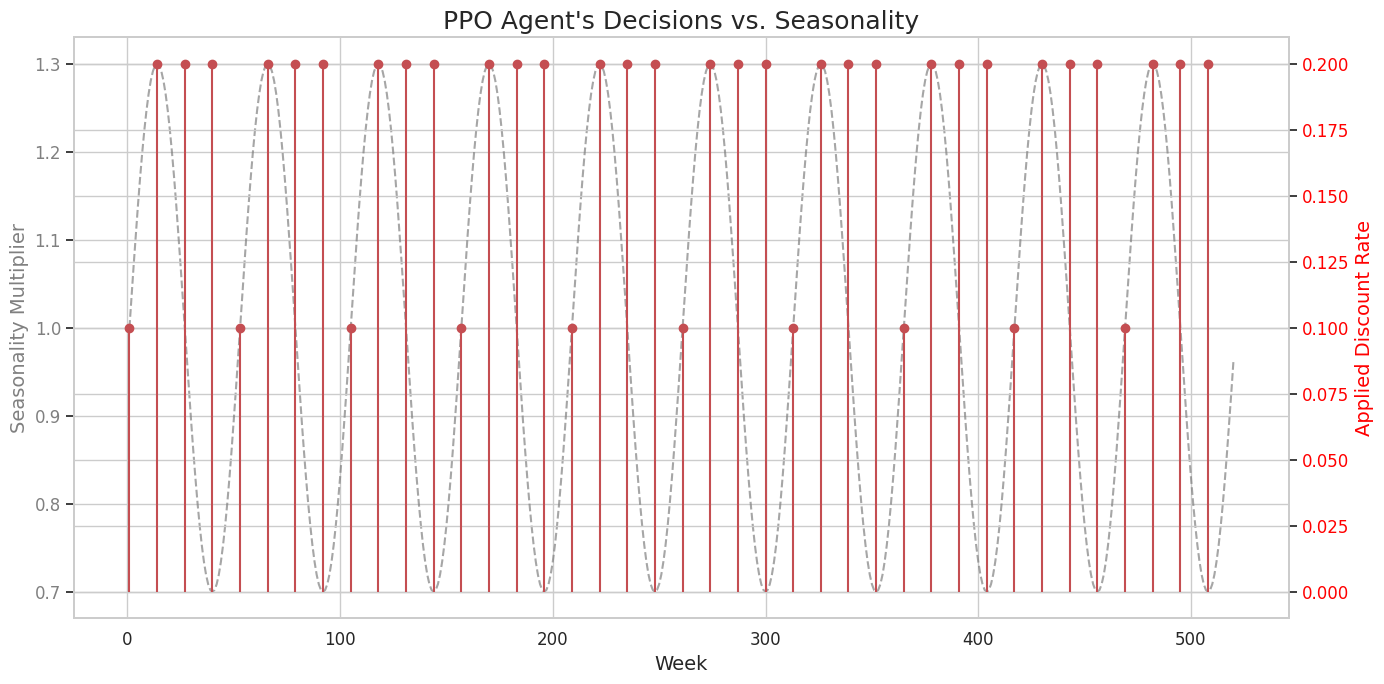

/tmp/ipython-input-1024388120.py:164: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decision_points = df[df['week'] % 13 == 1]; heatmap_data = decision_points.groupby(['seasonality_bin', 'loyalty_bin'])['discount'].mean().unstack()


-> Generating Figure 3.5: Strategy Heatmap...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


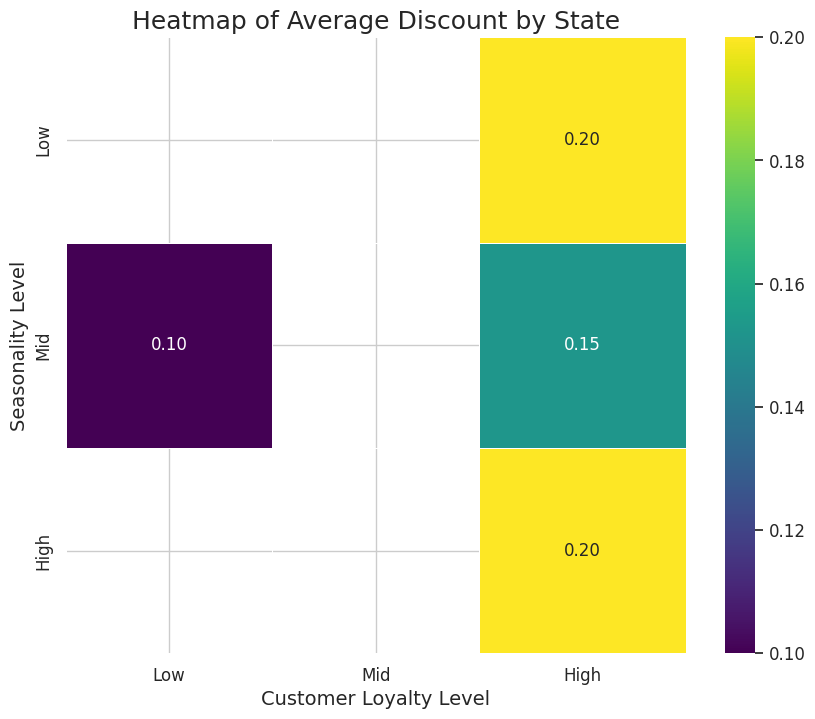


--- SECTION 4: CAUSAL INFERENCE ANALYSIS ---

Fitting the CausalForestDML model...


/usr/local/lib/python3.12/dist-packages/econml/sklearn_extensions/model_selection.py:550: UserWarning: Model LogisticRegressionCV(cv=3, max_iter=1000, random_state=123) has a non-default cv attribute, which will be ignored
  warnings.warn(f"Model {sub_model} has a non-default cv attribute, which will be ignored")
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:451: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  opt_res = optimize.minimize(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:451: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  opt_res = optimize.minimize(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:451: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are depre

Model training complete.

-> Generating Table 4.1: Average Treatment Effect (ATE) Results...
            Comparison Estimated ATE 95% Confidence Interval
0  20% vs 10% Discount       -133.07        [-256.78, -9.36]


-> Generating Figure 4.1: ATE Results with Confidence Intervals...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


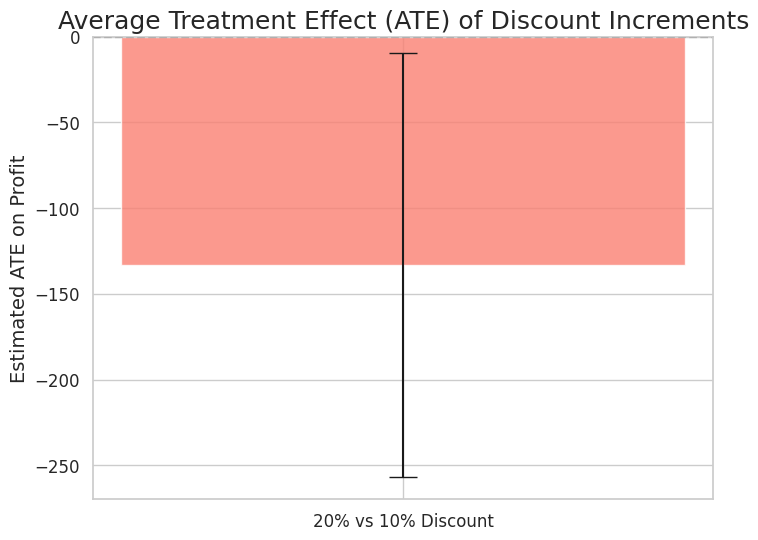

-> Generating Figure 4.2: Conditional Average Treatment Effect (CATE) Grid...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


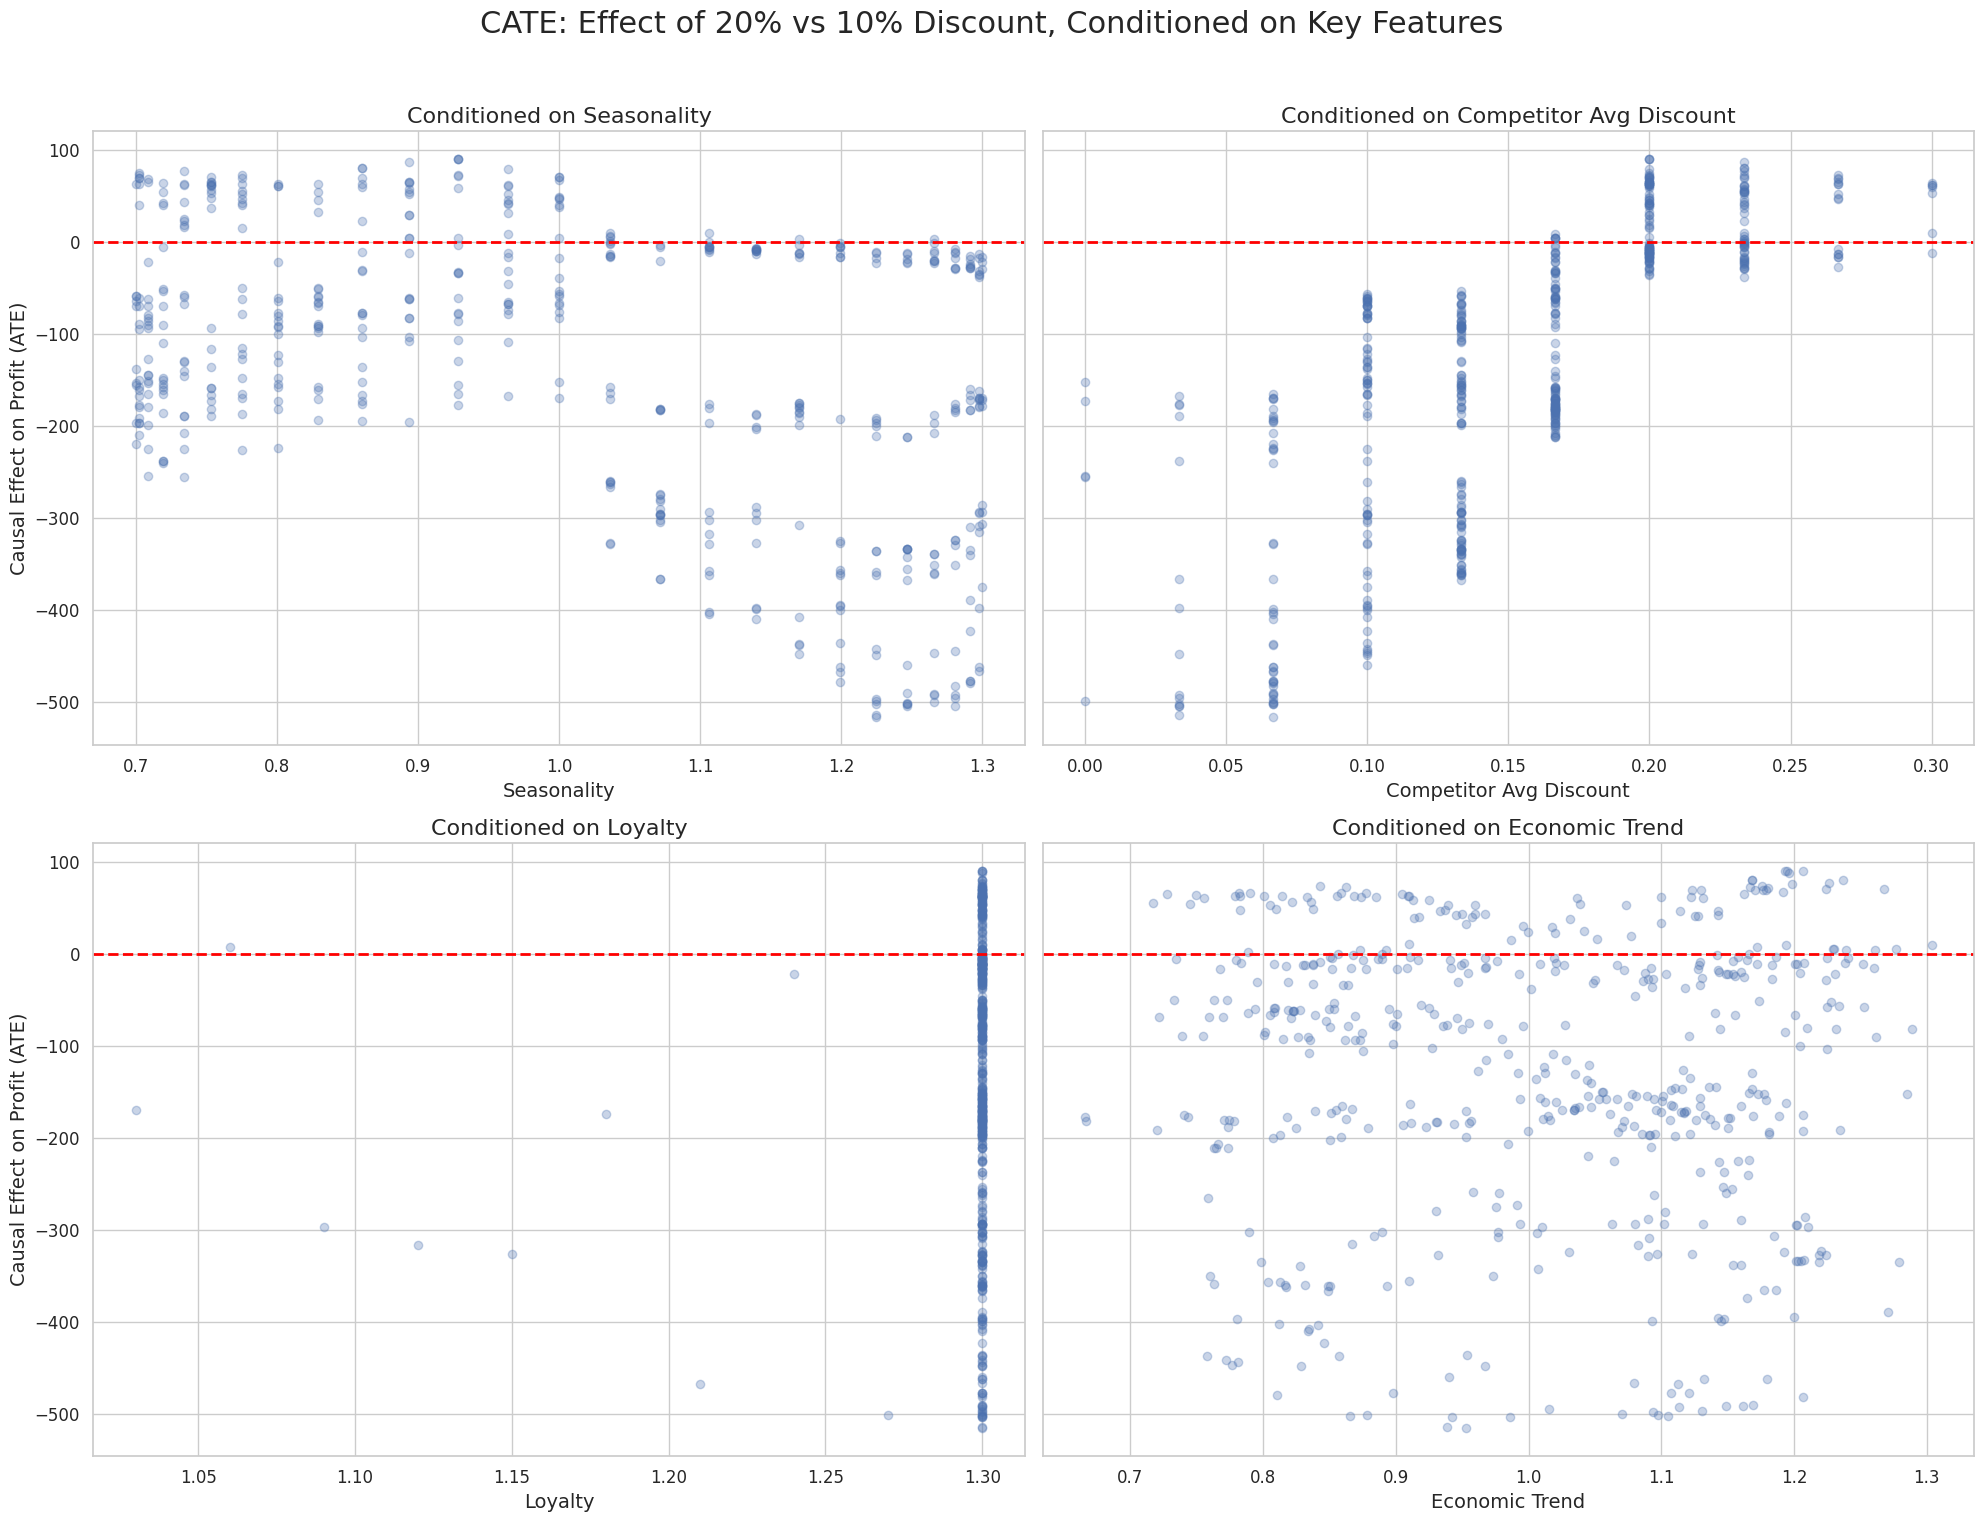


-> Generating and saving individual CATE plots...
   - Figure 4.3: CATE vs seasonality


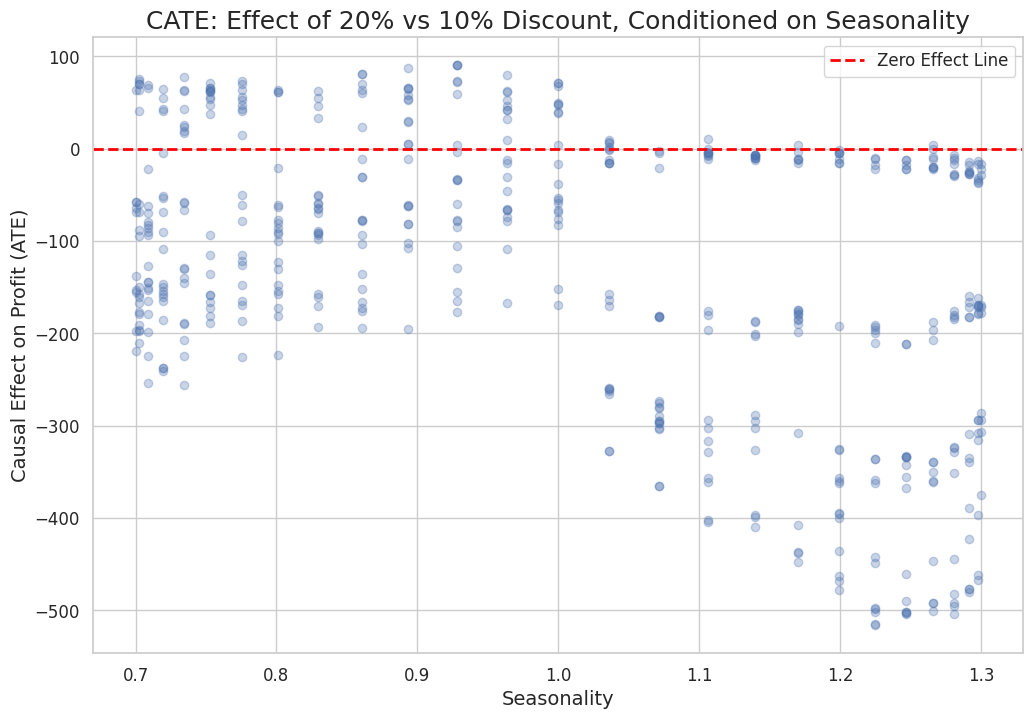

   - Figure 4.4: CATE vs competitor_avg_discount


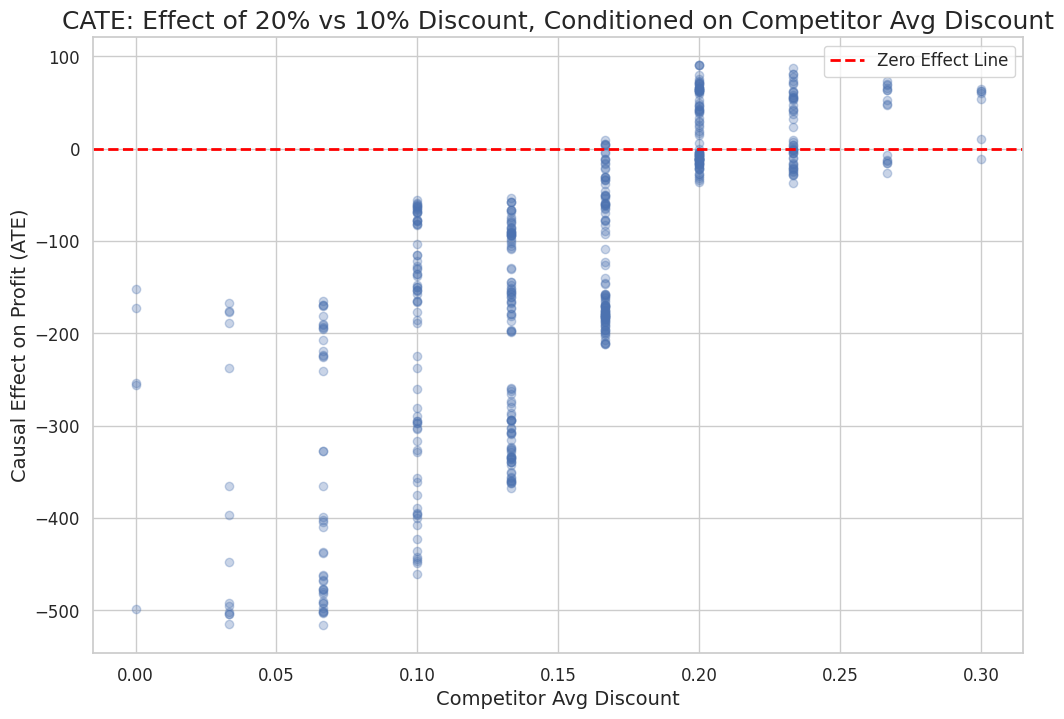

   - Figure 4.5: CATE vs loyalty


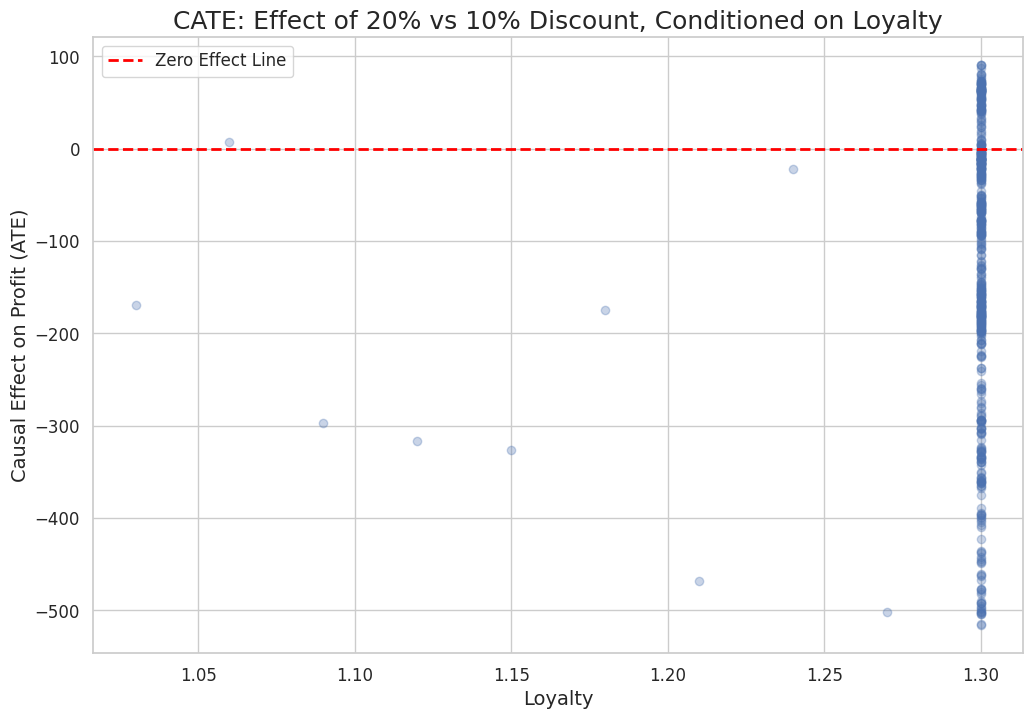

   - Figure 4.6: CATE vs economic_trend


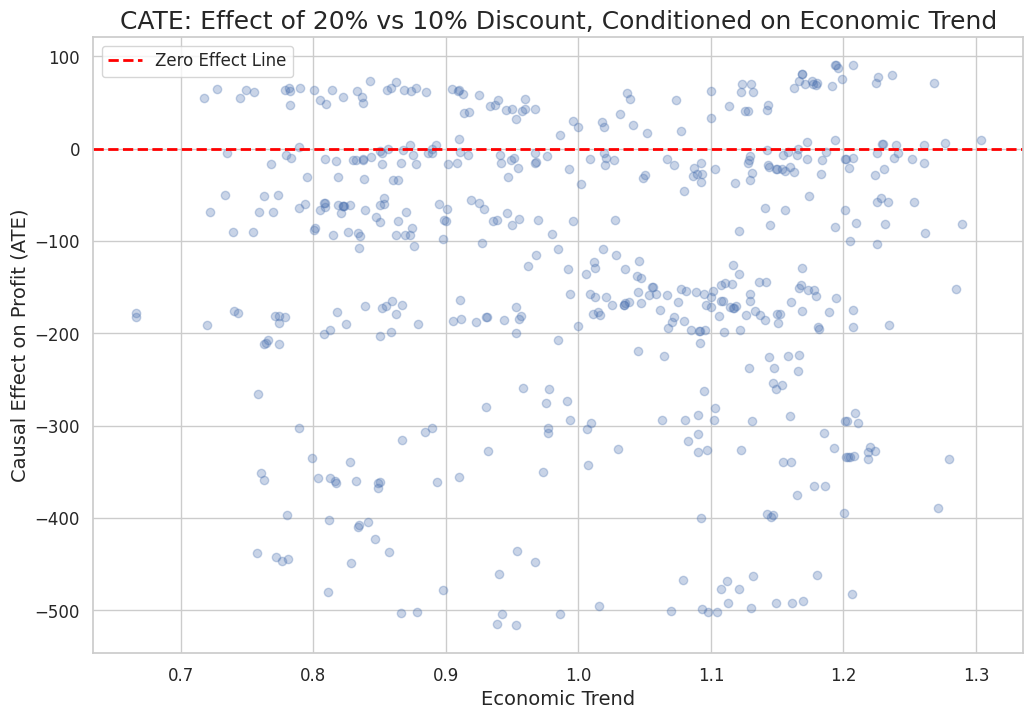


-> Generating Figure 5.1: Counterfactual Simulation...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


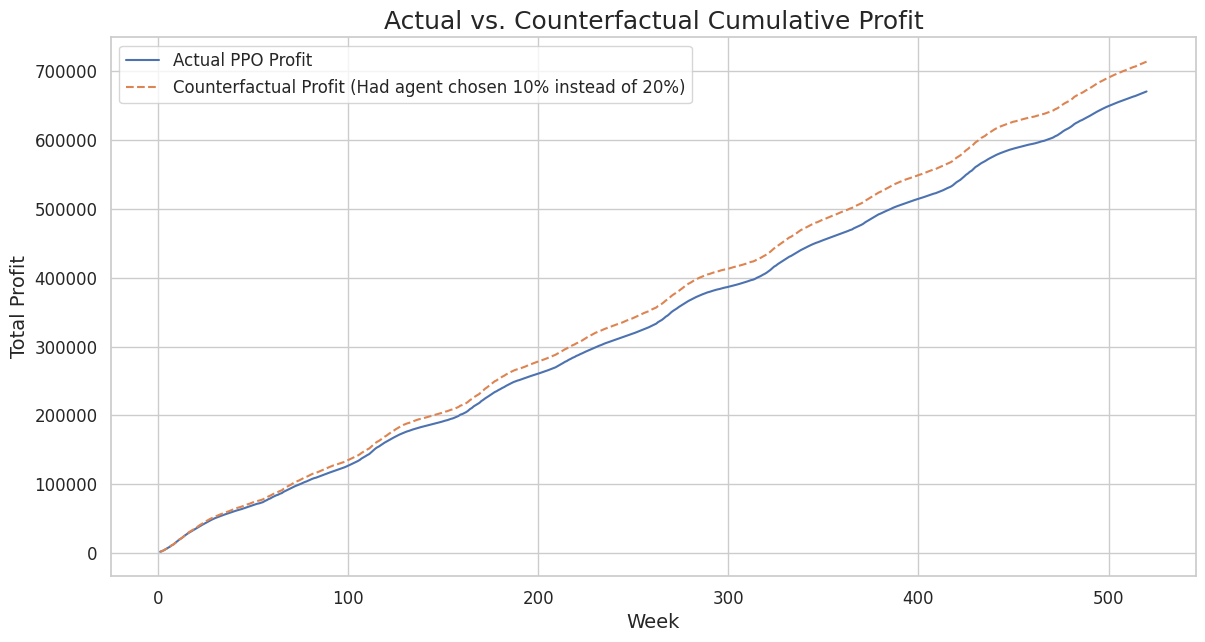


--- SECTION 5: DISCUSSION - THE COST OF THE ILLUSION ---

Causal Analysis Final Tally:
---------------------------------
Actual Total Profit (PPO Agent): 670,793.68
Counterfactual Total Profit (Optimal Strategy): 713,974.80
---------------------------------
Absolute Profit Lost (Opportunity Cost): 43,181.12
Percentage of Potential Profit Lost: 6.05%
---------------------------------


*** ALL ANALYSIS AND VISUALIZATIONS ARE COMPLETE! ***


In [4]:
# ==============================================================================
# CELL 3: Causal Analysis & Visualization (part2_analysis.py) - ROBUST VERSION
# ==============================================================================
print("Part 2: Starting Causal Analysis and Visualization...")

# We need all our libraries for this part
import numpy as np
import pandas as pd
import os
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from stable_baselines3 import PPO
from econml.dml import CausalForestDML
from sklearn.ensemble import GradientBoostingRegressor
# FIX: Import a more stable classifier for the treatment model
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold

# --- Style and Environment Setup ---
# This ensures our plots look consistent and professional
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# We need the environment definition again for the simulation
class CausalPricingEnv(gym.Env):
    def __init__(self, num_weeks=104):
        super().__init__()
        self.num_weeks = num_weeks; self.current_week = 0; self.base_price = 25; self.base_volume = 100;
        self.cost = 12.0; self.action_space = spaces.Discrete(4);
        self.observation_space = spaces.Box(low=-1, high=10, shape=(6,), dtype=np.float32)
        self.loyalty = 1.0; self.economic_trend = 1.0; self.past_discount = 0.0; self.current_discount = 0.0
    def reset(self, seed=None, options=None):
        super().reset(seed=seed); self.current_week = 0; self.loyalty = 1.0; self.economic_trend = 1.0;
        self.past_discount = 0.0; self.current_discount = 0.0; return self._get_obs(), {}
    def _get_obs(self):
        seasonality = 1 + 0.3 * np.sin(2 * np.pi * self.current_week / 52)
        competitor_discounts = np.random.choice([0.0, 0.1, 0.2, 0.3], p=[0.2, 0.3, 0.3, 0.2], size=3)
        competitor_avg_discount = np.mean(competitor_discounts)
        self.economic_trend = 1 + 0.2 * np.sin(2 * np.pi * self.current_week / 80) + np.random.normal(0, 0.05)
        return np.array([self.current_week % 52, seasonality, competitor_avg_discount, self.loyalty, self.economic_trend, self.past_discount], dtype=np.float32)
    def step(self, action):
        discount_levels = {0: 0.0, 1: 0.1, 2: 0.2, 3: 0.3}
        if self.current_week % 13 == 0: self.current_discount = discount_levels.get(action, 0.0)
        discount = self.current_discount; seasonality = 1 + 0.3 * np.sin(2 * np.pi * self.current_week / 52)
        competitor_avg_discount = self._get_obs()[2]; our_price = self.base_price * (1 - discount)
        avg_competitor_price = self.base_price * (1 - competitor_avg_discount)
        stockpiling_factor = max(0.5, 1 - (self.past_discount * 2.0))
        price_effect = np.log(1 + (self.base_price - our_price) / self.base_price * 5) + 1; loyalty_effect = self.loyalty ** 1.5
        competitor_price_ratio = avg_competitor_price / our_price
        competitor_impact = competitor_price_ratio ** 3 if competitor_price_ratio < 1.0 else competitor_price_ratio ** 0.5
        demand = self.base_volume * seasonality * loyalty_effect * self.economic_trend * stockpiling_factor * price_effect * competitor_impact
        if discount == 0.0: self.loyalty = max(self.loyalty - 0.02, 0.5)
        elif 0 < discount <= 0.2: self.loyalty = min(self.loyalty + 0.03, 1.3)
        else: self.loyalty = max(self.loyalty - 0.03, 0.5)
        self.past_discount = discount; profit = (our_price - self.cost) * demand; reward = profit
        if self.loyalty > 1.0: reward += (self.loyalty - 1.0) * 500
        if self.loyalty < 1.0: reward -= (1.0 - self.loyalty) * 1000
        if our_price < avg_competitor_price: reward += 300
        self.current_week += 1; terminated = self.current_week >= self.num_weeks; truncated = False
        info = {"profit": profit, "discount": discount, "competitor_avg_discount": competitor_avg_discount, "loyalty": self.loyalty, "economic_trend": self.economic_trend, "demand": demand, "seasonality": seasonality}
        return self._get_obs(), reward, terminated, truncated, info


# --- Data Generation for Analysis ---
def run_detailed_simulation(env, agent_policy, num_weeks, agent_name):
    obs, _ = env.reset(); data_points = []
    for week in range(num_weeks):
        if agent_name == "PPO Agent":
            action, _ = agent_policy.predict(obs, deterministic=True); action = action.item()
        elif agent_name == "Random Agent": action = env.action_space.sample()
        else: action = 0
        obs, _, terminated, truncated, info = env.step(action)
        info['week'] = env.current_week; info['agent'] = agent_name; data_points.append(info)
        if terminated or truncated: break
    return pd.DataFrame(data_points)

def generate_simulation_data(model_path, num_weeks, output_csv):
    if os.path.exists(output_csv):
        print(f"Found '{output_csv}'. Loading data directly from the file.")
        return pd.read_csv(output_csv)
    print("--- Starting Detailed Simulation for Analysis ---")
    try: ppo_model = PPO.load(model_path); print(f"Trained model loaded successfully from '{model_path}'")
    except FileNotFoundError: print(f"FATAL ERROR: Model file not found at '{model_path}'. Please run Cell 2 first!"); return None
    ppo_env = CausalPricingEnv(num_weeks=num_weeks); random_env = CausalPricingEnv(num_weeks=num_weeks); static_env = CausalPricingEnv(num_weeks=num_weeks)
    print("Running simulation for PPO Agent..."); ppo_df = run_detailed_simulation(ppo_env, ppo_model, num_weeks, "PPO Agent")
    print("Running simulation for Random Agent..."); random_df = run_detailed_simulation(random_env, None, num_weeks, "Random Agent")
    print("Running simulation for Static Agent..."); static_df = run_detailed_simulation(static_env, None, num_weeks, "Static Agent")
    all_data = pd.concat([ppo_df, random_df, static_df], ignore_index=True)
    all_data.to_csv(output_csv, index=False)
    print(f"Simulation data saved to '{output_csv}' for future runs.\n")
    return all_data


# --- All Analysis and Visualization Functions ---

def generate_and_plot_dag():
    print("-> Generating Figure 2.1: The Causal Model (DAG)...")
    causal_graph_str = """
    digraph {
        rankdir=LR; node [shape=box, style="rounded,filled", fillcolor=lightgrey];
        discount [label="Discount Decision (Treatment)", fillcolor=lightblue];
        profit [label="Profit (Outcome)", fillcolor=lightgreen];
        seasonality; economic_trend; loyalty; competitor_avg_discount [label="Competitor Discount"];
        {seasonality, economic_trend, competitor_avg_discount} -> discount;
        {seasonality, economic_trend, loyalty, competitor_avg_discount, discount} -> profit;
        discount -> loyalty;
    }"""
    graph = graphviz.Source(causal_graph_str, filename="Causal_DAG_Final", format="png")
    graph.render(view=False)
    print("   Saved as 'Causal_DAG_Final.png'.\n")

def generate_kpi_table(df):
    print("-> Generating Table 3.1: Key Performance Indicators (KPIs)...")
    kpi_df = df.groupby('agent')['profit'].agg(['sum', 'mean', 'std']).reset_index()
    kpi_df.columns = ['Agent', 'Total Profit', 'Average Weekly Profit', 'Profit Volatility (Std Dev)']
    kpi_df = kpi_df.round(2); print(kpi_df); print("\n")
    return kpi_df

def plot_cumulative_profit(df):
    print("-> Generating Figure 3.1: Cumulative Profit Performance...")
    plt.figure();
    for agent in df['agent'].unique():
        agent_data = df[df['agent'] == agent].copy()
        agent_data['cumulative_profit'] = agent_data['profit'].cumsum()
        plt.plot(agent_data['week'], agent_data['cumulative_profit'], label=agent)
    plt.title('Cumulative Profit Performance of Agents'); plt.xlabel('Week'); plt.ylabel('Total Profit'); plt.legend(); plt.grid(True); plt.show()

def plot_rolling_profit(df):
    print("-> Generating Figure 3.2: 52-Week Rolling Average Profit...")
    plt.figure()
    for agent in df['agent'].unique():
        agent_data = df[df['agent'] == agent]
        plt.plot(agent_data['week'], agent_data['profit'].rolling(window=52).mean(), label=f'{agent} (52-Week Avg)')
    plt.title('52-Week Rolling Average Profit'); plt.xlabel('Week'); plt.ylabel('Average Weekly Profit'); plt.legend(); plt.grid(True); plt.show()

def plot_agent_strategy_distribution(ppo_df):
    print("-> Generating Figure 3.3: PPO Agent's Discount Distribution...")
    decision_points = ppo_df[ppo_df['week'] % 13 == 1]; plt.figure()
    sns.countplot(x='discount', data=decision_points, palette='viridis', order=[0.0, 0.1, 0.2, 0.3])
    plt.title("Distribution of Discount Levels Chosen by PPO Agent"); plt.xlabel("Discount Rate"); plt.ylabel("Number of Decisions"); plt.show()

def plot_agent_strategy_vs_seasonality(ppo_df):
    print("-> Generating Figure 3.4: PPO Agent's Decisions vs. Seasonality...")
    decision_points = ppo_df[ppo_df['week'] % 13 == 1]; fig, ax1 = plt.subplots()
    ax1.plot(ppo_df['week'], ppo_df['seasonality'], color='gray', linestyle='--', label='Seasonality', alpha=0.7)
    ax1.set_xlabel('Week'); ax1.set_ylabel('Seasonality Multiplier', color='gray'); ax1.tick_params(axis='y', labelcolor='gray')
    ax2 = ax1.twinx()
    ax2.stem(decision_points['week'], decision_points['discount'], linefmt='-r', markerfmt='or', basefmt=" ", label='PPO Discount Decision')
    ax2.set_ylabel('Applied Discount Rate', color='red'); ax2.tick_params(axis='y', labelcolor='red')
    plt.title("PPO Agent's Decisions vs. Seasonality"); fig.tight_layout(); plt.grid(True); plt.show()

def plot_strategy_heatmap(ppo_df):
    print("-> Generating Figure 3.5: Strategy Heatmap...")
    df = ppo_df.copy(); df['seasonality_bin'] = pd.cut(df['seasonality'], bins=3, labels=['Low', 'Mid', 'High'])
    df['loyalty_bin'] = pd.cut(df['loyalty'], bins=3, labels=['Low', 'Mid', 'High'])
    decision_points = df[df['week'] % 13 == 1]; heatmap_data = decision_points.groupby(['seasonality_bin', 'loyalty_bin'])['discount'].mean().unstack()
    plt.figure(figsize=(10, 8)); sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="viridis", linewidths=.5)
    plt.title('Heatmap of Average Discount by State'); plt.xlabel('Customer Loyalty Level'); plt.ylabel('Seasonality Level'); plt.show()

def perform_full_causal_analysis(ppo_df):
    print("\n--- SECTION 4: CAUSAL INFERENCE ANALYSIS ---\n")
    confounders = ['seasonality', 'economic_trend', 'loyalty', 'competitor_avg_discount']; Y = ppo_df['profit']; T = ppo_df['discount']; X = ppo_df[confounders]

    # Define the nuisance models
    model_y = GradientBoostingRegressor(n_estimators=100, max_depth=4, random_state=42)
    # FIX: Using a more robust model for the imbalanced treatment data.
    model_t = LogisticRegressionCV(cv=3, random_state=123, max_iter=1000)

    # The main Causal Model
    dml_estimator = CausalForestDML(
        model_y=model_y,
        model_t=model_t,
        discrete_treatment=True,
        categories='auto',
        random_state=123
    )

    print("Fitting the CausalForestDML model..."); dml_estimator.fit(Y, T, X=X); print("Model training complete.\n")

    print("-> Generating Table 4.1: Average Treatment Effect (ATE) Results...")
    # We can only compare the treatments that were actually observed in the PPO agent's data.
    pairs = [(0.1, 0.2)]; results = []
    for t0, t1 in pairs:
        ate = dml_estimator.ate(X=X, T0=t0, T1=t1); interval = dml_estimator.ate_interval(X=X, T0=t0, T1=t1)
        results.append({"Comparison": f"{t1*100:.0f}% vs {t0*100:.0f}% Discount", "Estimated ATE": f"{ate:.2f}", "95% Confidence Interval": f"[{interval[0]:.2f}, {interval[1]:.2f}]"})
    ate_table = pd.DataFrame(results); print(ate_table); print("\n")

    print("-> Generating Figure 4.1: ATE Results with Confidence Intervals...")
    if results:
        ates = [float(r['Estimated ATE']) for r in results]; labels = [r['Comparison'] for r in results]
        intervals = [[float(val) for val in r['95% Confidence Interval'].strip('[]').split(', ')] for r in results]
        errors = [(interval[1] - interval[0]) / 2 for interval in intervals]
        plt.figure(figsize=(8, 6)); plt.bar(labels, ates, yerr=errors, capsize=10, color=['salmon'], alpha=0.8)
        plt.axhline(0, color='black', linestyle='--'); plt.ylabel('Estimated ATE on Profit'); plt.title('Average Treatment Effect (ATE) of Discount Increments'); plt.show()

    # CATE Analysis
    T0, T1 = 0.1, 0.2; cate_effects = dml_estimator.effect(X, T0=T0, T1=T1)

    print("-> Generating Figure 4.2: Conditional Average Treatment Effect (CATE) Grid...")
    fig, axes = plt.subplots(2, 2, figsize=(20, 16), sharey=True)
    fig.suptitle(f'CATE: Effect of {T1*100:.0f}% vs {T0*100:.0f}% Discount, Conditioned on Key Features', fontsize=22)
    confounders_to_plot = ['seasonality', 'competitor_avg_discount', 'loyalty', 'economic_trend']
    for i, conf in enumerate(confounders_to_plot):
        ax = axes[i // 2, i % 2]; ax.scatter(X[conf], cate_effects, alpha=0.3); ax.axhline(0, color='red', linestyle='--', linewidth=2)
        ax.set_xlabel(f'{conf.replace("_", " ").title()}'); ax.set_title(f'Conditioned on {conf.replace("_", " ").title()}', fontsize=16); ax.grid(True)
        if i % 2 == 0: ax.set_ylabel('Causal Effect on Profit (ATE)')
    plt.tight_layout(rect=[0, 0.03, 1, 0.96]); plt.show()

    print("\n-> Generating and saving individual CATE plots...")
    for i, conf in enumerate(confounders_to_plot):
        print(f"   - Figure 4.{3+i}: CATE vs {conf}")
        plt.figure(figsize=(12,8)); plt.scatter(X[conf], cate_effects, alpha=0.3); plt.axhline(0, color='red', linestyle='--', linewidth=2, label='Zero Effect Line')
        plt.title(f'CATE: Effect of {T1*100:.0f}% vs {T0*100:.0f}% Discount, Conditioned on {conf.replace("_", " ").title()}', fontsize=18)
        plt.xlabel(f'{conf.replace("_", " ").title()}', fontsize=14); plt.ylabel('Causal Effect on Profit (ATE)', fontsize=14)
        plt.legend(); plt.grid(True); plt.savefig(f"cate_vs_{conf}.png", dpi=150, bbox_inches='tight'); plt.show()

    print("\n-> Generating Figure 5.1: Counterfactual Simulation...")
    df = ppo_df.copy(); action_T1_indices = df[df['discount'] == 0.2].index; X_T1 = X.loc[action_T1_indices]
    effect_of_T1_vs_T0 = dml_estimator.effect(X_T1, T0=0.1, T1=0.2)
    df['counterfactual_profit'] = df['profit']; df.loc[action_T1_indices, 'counterfactual_profit'] -= effect_of_T1_vs_T0
    df['cumulative_profit_actual'] = df['profit'].cumsum(); df['cumulative_profit_counterfactual'] = df['counterfactual_profit'].cumsum()
    plt.figure(); plt.plot(df['week'], df['cumulative_profit_actual'], label='Actual PPO Profit')
    plt.plot(df['week'], df['cumulative_profit_counterfactual'], label='Counterfactual Profit (Had agent chosen 10% instead of 20%)', linestyle='--')
    plt.title('Actual vs. Counterfactual Cumulative Profit'); plt.xlabel('Week'); plt.ylabel('Total Profit'); plt.legend(); plt.grid(True); plt.show()

    print("\n--- SECTION 5: DISCUSSION - THE COST OF THE ILLUSION ---\n")
    final_actual_profit = df['cumulative_profit_actual'].iloc[-1]
    final_counterfactual_profit = df['cumulative_profit_counterfactual'].iloc[-1]
    absolute_loss = final_counterfactual_profit - final_actual_profit
    relative_loss_percentage = (absolute_loss / final_counterfactual_profit) * 100
    print("Causal Analysis Final Tally:")
    print("---------------------------------")
    print(f"Actual Total Profit (PPO Agent): {final_actual_profit:,.2f}")
    print(f"Counterfactual Total Profit (Optimal Strategy): {final_counterfactual_profit:,.2f}")
    print("---------------------------------")
    print(f"Absolute Profit Lost (Opportunity Cost): {absolute_loss:,.2f}")
    print(f"Percentage of Potential Profit Lost: {relative_loss_percentage:.2f}%")
    print("---------------------------------\n")

def main():
    """Main function to run the entire analysis workflow."""
    MODEL_FILE_PATH = "ppo_causal_pricing_model_phase_2.zip"
    SIMULATION_WEEKS = 520
    OUTPUT_CSV_FILE = "simulation_results.csv"
    simulation_data = generate_simulation_data(model_path=MODEL_FILE_PATH, num_weeks=SIMULATION_WEEKS, output_csv=OUTPUT_CSV_FILE)
    if simulation_data is not None:
        ppo_data = simulation_data[simulation_data['agent'] == 'PPO Agent'].copy()
        print("\n--- SECTION 2: METHODOLOGY VISUALS ---\n"); generate_and_plot_dag()
        print("\n--- SECTION 3.1: AGENT PERFORMANCE ANALYSIS ---\n"); generate_kpi_table(simulation_data); plot_cumulative_profit(simulation_data); plot_rolling_profit(simulation_data)
        print("\n--- SECTION 3.2: PPO AGENT'S POLICY ANALYSIS ---\n"); plot_agent_strategy_distribution(ppo_data); plot_agent_strategy_vs_seasonality(ppo_data); plot_strategy_heatmap(ppo_data)
        perform_full_causal_analysis(ppo_data)
        print("\n*** ALL ANALYSIS AND VISUALIZATIONS ARE COMPLETE! ***")

# --- Main Execution Block ---
main()